In [2]:
# Notebook setup
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib  # Enable Japanese fonts in Matplotlib

In [3]:
from pathlib import Path
from typing import List

import pandas as pd

COLUMN_MAP = {
    "商品名": "product",
    "説明": "description",
    "方向": "direction",
    "約定日": "trade_date",
    "対象期間(自)": "period_start",
    "対象期間(至)": "period_end",
    "売り入札量(MW)": "offer_mw",
    "約定価格(円/kWh)": "settlement_price_yen_per_kwh",
    "約定量(MW)": "settled_mw",
}
DATE_COLS = ["trade_date", "period_start", "period_end"]
NUM_COLS = ["offer_mw", "settlement_price_yen_per_kwh", "settled_mw"]


def _coerce_numeric(series: pd.Series) -> pd.Series:
    # Handle '-', empty, and strings; remove commas and spaces
    s = (
        series.astype(str)
        .str.replace(",", "", regex=False)
        .str.strip()
        .replace({"-": None, "": None})
    )
    return pd.to_numeric(s, errors="coerce")


def load_transmission_rights(raw_dir_path: str | Path) -> pd.DataFrame:
    raw_dir = Path(raw_dir_path)
    files: List[Path] = sorted(raw_dir.glob("transmission_rights_*.csv"))
    if not files:
        raise FileNotFoundError(f"No files matched in {raw_dir}")

    frames: List[pd.DataFrame] = []
    for f in files:
        try:
            df = pd.read_csv(f, encoding="cp932")
        except UnicodeDecodeError:
            df = pd.read_csv(f, encoding="shift_jis")
        df["source_file"] = f.name
        # Rename columns if present
        existing_map = {k: v for k, v in COLUMN_MAP.items() if k in df.columns}
        if existing_map:
            df = df.rename(columns=existing_map)
        frames.append(df)

    out = pd.concat(frames, ignore_index=True)

    # Parse dates
    for c in DATE_COLS:
        if c in out.columns:
            out[c] = pd.to_datetime(out[c], errors="coerce")

    # Parse numerics
    for c in NUM_COLS:
        if c in out.columns:
            out[c] = _coerce_numeric(out[c])

    return out


# Run loader
transmission_df = load_transmission_rights(
    "/Users/hankehly/Projects/adhoc-energy-analytics/data/raw"
)
print(
    f"Loaded {transmission_df.shape[0]:,} rows from {transmission_df['source_file'].nunique()} files"
)
print(transmission_df.dtypes)
transmission_df.head()

Loaded 2,087 rows from 7 files
product                                 object
description                             object
direction                               object
trade_date                      datetime64[ns]
period_start                    datetime64[ns]
period_end                      datetime64[ns]
offer_mw                               float64
settlement_price_yen_per_kwh           float64
settled_mw                             float64
source_file                             object
dtype: object


,product,description,direction,trade_date,period_start,period_end,offer_mw,settlement_price_yen_per_kwh,settled_mw,source_file
0,19W23T21,6月1週北本[逆],東北 -> 北海道,2019-04-24,2019-06-01,2019-06-07,0.0,NaN,NaN,transmission_rights_2019.csv
1,19W23T34,6月1週ＦＣ(順),東京 -> 中部,2019-04-24,2019-06-01,2019-06-07,600.0,NaN,NaN,transmission_rights_2019.csv
2,19W23T43,6月1週ＦＣ[逆],中部 -> 東京,2019-04-24,2019-06-01,2019-06-07,212.0,1.0,212.0,transmission_rights_2019.csv
3,19W23T86,6月1週阿南紀北[逆],四国 -> 関西,2019-04-24,2019-06-01,2019-06-07,69.7,NaN,NaN,transmission_rights_2019.csv
4,19W23T87,6月1週本四[逆],四国 -> 中国,2019-04-24,2019-06-01,2019-06-07,983.6,NaN,NaN,transmission_rights_2019.csv


In [5]:
transmission_df[transmission_df.source_file == "transmission_rights_2022.csv"]

,product,description,direction,trade_date,period_start,period_end,offer_mw,settlement_price_yen_per_kwh,settled_mw,source_file
936,22W22T21,6月1週北本[逆],東北 -> 北海道,2022-04-22,2022-05-28,2022-06-03,368.0,0.01,34.1,transmission_rights_2022.csv
937,22W22T34,6月1週ＦＣ(順),東京 -> 中部,2022-04-22,2022-05-28,2022-06-03,1200.0,NaN,NaN,transmission_rights_2022.csv
938,22W22T43,6月1週ＦＣ[逆],中部 -> 東京,2022-04-22,2022-05-28,2022-06-03,862.0,0.01,632.4,transmission_rights_2022.csv
939,22W22T86,6月1週阿南紀北[逆],四国 -> 関西,2022-04-22,2022-05-28,2022-06-03,1006.0,NaN,NaN,transmission_rights_2022.csv
940,22W22T87,6月1週本四[逆],四国 -> 中国,2022-04-22,2022-05-28,2022-06-03,1054.0,NaN,NaN,transmission_rights_2022.csv
...,...,...,...,...,...,...,...,...,...,...
1243,23W21T34,5月4週ＦＣ(順),東京 -> 中部,2023-03-23,2023-05-20,2023-05-26,1200.0,NaN,NaN,transmission_rights_2022.csv
1244,23W21T43,5月4週ＦＣ[逆],中部 -> 東京,2023-03-23,2023-05-20,2023-05-26,262.0,1.10,262.0,transmission_rights_2022.csv
1245,23W21T86,5月4週阿南紀北[逆],四国 -> 関西,2023-03-23,2023-05-20,2023-05-26,739.0,0.01,68.0,transmission_rights_2022.csv
1246,23W21T87,5月4週本四[逆],四国 -> 中国,2023-03-23,2023-05-20,2023-05-26,1001.0,NaN,NaN,transmission_rights_2022.csv


In [13]:
transmission_df.groupby("source_file").direction.nunique()

source_file
transmission_rights_2019.csv    6
transmission_rights_2020.csv    6
transmission_rights_2021.csv    6
transmission_rights_2022.csv    6
transmission_rights_2023.csv    6
transmission_rights_2024.csv    6
transmission_rights_2025.csv    6
Name: direction, dtype: int64

In [7]:
# Check min/max trade_date per file
date_ranges = transmission_df.groupby('source_file')['trade_date'].agg(['min', 'max']).sort_index()
print("Trade date ranges by file:")
date_ranges

Trade date ranges by file:


,min,max
source_file,,
transmission_rights_2019.csv,2019-04-24,2020-03-25
transmission_rights_2020.csv,2020-04-22,2021-03-24
transmission_rights_2021.csv,2021-04-22,2022-03-24
transmission_rights_2022.csv,2022-04-22,2023-03-23
transmission_rights_2023.csv,2023-04-24,2024-03-25
transmission_rights_2024.csv,2024-04-24,2025-03-25
transmission_rights_2025.csv,2025-04-23,2025-11-25


In [8]:
# Check min/max period_start and period_end per file
period_ranges = transmission_df.groupby('source_file')[['period_start', 'period_end']].agg(['min', 'max'])
print("Period date ranges by file:")
print("="*80)
for file in period_ranges.index:
    ps_min = period_ranges.loc[file, ('period_start', 'min')]
    ps_max = period_ranges.loc[file, ('period_start', 'max')]
    pe_min = period_ranges.loc[file, ('period_end', 'min')]
    pe_max = period_ranges.loc[file, ('period_end', 'max')]
    print(f"\n{file}")
    print(f"  period_start: {ps_min} to {ps_max}")
    print(f"  period_end:   {pe_min} to {pe_max}")

Period date ranges by file:

transmission_rights_2019.csv
  period_start: 2019-06-01 00:00:00 to 2020-05-23 00:00:00
  period_end:   2019-06-07 00:00:00 to 2020-05-29 00:00:00

transmission_rights_2020.csv
  period_start: 2020-05-30 00:00:00 to 2021-05-22 00:00:00
  period_end:   2020-06-05 00:00:00 to 2021-05-28 00:00:00

transmission_rights_2021.csv
  period_start: 2021-05-29 00:00:00 to 2022-05-21 00:00:00
  period_end:   2021-06-04 00:00:00 to 2022-05-27 00:00:00

transmission_rights_2022.csv
  period_start: 2022-05-28 00:00:00 to 2023-05-20 00:00:00
  period_end:   2022-06-03 00:00:00 to 2023-05-26 00:00:00

transmission_rights_2023.csv
  period_start: 2023-05-27 00:00:00 to 2024-05-25 00:00:00
  period_end:   2023-06-02 00:00:00 to 2024-05-31 00:00:00

transmission_rights_2024.csv
  period_start: 2024-06-01 00:00:00 to 2025-05-24 00:00:00
  period_end:   2024-06-07 00:00:00 to 2025-05-30 00:00:00

transmission_rights_2025.csv
  period_start: 2025-05-31 00:00:00 to 2026-01-24 00:0

In [14]:
# Distribution of days between period_start and period_end
transmission_df['period_days'] = (transmission_df['period_end'] - transmission_df['period_start']).dt.days

print("Distribution of period duration (days between period_start and period_end):")
print("="*80)
print(f"Overall stats:")
print(f"  Min:    {transmission_df['period_days'].min()} days")
print(f"  Max:    {transmission_df['period_days'].max()} days")
print(f"  Mean:   {transmission_df['period_days'].mean():.2f} days")
print(f"  Median: {transmission_df['period_days'].median():.1f} days")
print(f"  Std:    {transmission_df['period_days'].std():.2f} days")

print(f"\nValue counts:")
print(transmission_df['period_days'].value_counts().sort_index())

print(f"\nDistribution by file:")
for file in sorted(transmission_df['source_file'].unique()):
    subset = transmission_df[transmission_df['source_file'] == file]['period_days']
    print(f"  {file}: min={subset.min()}, max={subset.max()}, mean={subset.mean():.2f}, count={len(subset)}")

Distribution of period duration (days between period_start and period_end):
Overall stats:
  Min:    6 days
  Max:    6 days
  Mean:   6.00 days
  Median: 6.0 days
  Std:    0.00 days

Value counts:
period_days
6    2087
Name: count, dtype: int64

Distribution by file:
  transmission_rights_2019.csv: min=6, max=6, mean=6.00, count=312
  transmission_rights_2020.csv: min=6, max=6, mean=6.00, count=312
  transmission_rights_2021.csv: min=6, max=6, mean=6.00, count=312
  transmission_rights_2022.csv: min=6, max=6, mean=6.00, count=312
  transmission_rights_2023.csv: min=6, max=6, mean=6.00, count=317
  transmission_rights_2024.csv: min=6, max=6, mean=6.00, count=312
  transmission_rights_2025.csv: min=6, max=6, mean=6.00, count=210


In [15]:
# Check if periods have gaps or continuous coverage
print("Checking for gaps in period coverage...")
print("="*80)

# Find overall date range
min_date = transmission_df['period_start'].min()
max_date = transmission_df['period_end'].max()
print(f"Overall period range: {min_date.date()} to {max_date.date()}")

# Create a full date range for the dataset
full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')
print(f"Total days in range: {len(full_date_range):,}")

# Create a set of all days covered by any period
covered_days = set()
for _, row in transmission_df.iterrows():
    period_dates = pd.date_range(start=row['period_start'], end=row['period_end'], freq='D')
    covered_days.update(period_dates)

covered_days_sorted = sorted(covered_days)
print(f"Days covered by at least one period: {len(covered_days_sorted):,}")

# Find gaps (uncovered days)
uncovered_days = [d for d in full_date_range if d not in covered_days]
print(f"Days NOT covered by any period: {len(uncovered_days)}")

if uncovered_days:
    print("\nGaps found:")
    # Group consecutive uncovered days
    gaps = []
    gap_start = uncovered_days[0]
    gap_end = uncovered_days[0]
    for day in uncovered_days[1:]:
        if (day - gap_end).days == 1:
            gap_end = day
        else:
            gaps.append((gap_start, gap_end))
            gap_start = day
            gap_end = day
    gaps.append((gap_start, gap_end))
    
    for gap_start, gap_end in gaps[:10]:  # Show first 10 gaps
        print(f"  {gap_start.date()} to {gap_end.date()} ({(gap_end - gap_start).days + 1} days)")
    if len(gaps) > 10:
        print(f"  ... and {len(gaps) - 10} more gaps")
else:
    print("\n✓ No gaps found! Every day is covered by at least one period.")

Checking for gaps in period coverage...
Overall period range: 2019-06-01 to 2026-01-30
Total days in range: 2,436
Days covered by at least one period: 2,436
Days NOT covered by any period: 0

✓ No gaps found! Every day is covered by at least one period.


In [19]:
transmission_df[transmission_df.direction == "中部 -> 東京"][["period_start", "period_end"]].sort_values("period_start")

,period_start,period_end
2,2019-06-01,2019-06-07
8,2019-06-08,2019-06-14
14,2019-06-15,2019-06-21
20,2019-06-22,2019-06-28
26,2019-06-29,2019-07-05
...,...,...
2059,2025-12-27,2026-01-02
2065,2026-01-03,2026-01-09
2071,2026-01-10,2026-01-16
2077,2026-01-17,2026-01-23


In [20]:
# Check day of week for period_start and period_end
transmission_df['period_start_dow'] = transmission_df['period_start'].dt.day_name()
transmission_df['period_end_dow'] = transmission_df['period_end'].dt.day_name()

print("Day of week distribution for period boundaries:")
print("="*80)

print("\nperiod_start day of week:")
print(transmission_df['period_start_dow'].value_counts())

print("\nperiod_end day of week:")
print(transmission_df['period_end_dow'].value_counts())

# Check if period_start and period_end are ever on the same day of week
same_dow = (transmission_df['period_start_dow'] == transmission_df['period_end_dow']).sum()
print(f"\nRecords where period_start and period_end are on the SAME day of week: {same_dow}")
print(f"Records where period_start and period_end are on DIFFERENT days of week: {len(transmission_df) - same_dow}")

# Sample a few rows to see the pattern
print("\nSample period start/end day-of-week pairs:")
sample = transmission_df[['period_start', 'period_start_dow', 'period_end', 'period_end_dow']].drop_duplicates('period_start_dow').head(3)
for idx, row in sample.iterrows():
    print(f"  {row['period_start'].date()} ({row['period_start_dow']}) → {row['period_end'].date()} ({row['period_end_dow']})")

Day of week distribution for period boundaries:

period_start day of week:
period_start_dow
Saturday    2087
Name: count, dtype: int64

period_end day of week:
period_end_dow
Friday    2087
Name: count, dtype: int64

Records where period_start and period_end are on the SAME day of week: 0
Records where period_start and period_end are on DIFFERENT days of week: 2087

Sample period start/end day-of-week pairs:
  2019-06-01 (Saturday) → 2019-06-07 (Friday)


In [21]:
# Analyze days between trade_date and period_start
transmission_df['days_to_period'] = (transmission_df['period_start'] - transmission_df['trade_date']).dt.days

print("Days between trade_date and period_start:")
print("="*80)
print(f"Overall stats:")
print(f"  Min:    {transmission_df['days_to_period'].min()} days")
print(f"  Max:    {transmission_df['days_to_period'].max()} days")
print(f"  Mean:   {transmission_df['days_to_period'].mean():.2f} days")
print(f"  Median: {transmission_df['days_to_period'].median():.1f} days")
print(f"  Std:    {transmission_df['days_to_period'].std():.2f} days")

print(f"\nValue counts (most common lead times):")
print(transmission_df['days_to_period'].value_counts().sort_index().head(15))

print(f"\nDistribution by file:")
for file in sorted(transmission_df['source_file'].unique()):
    subset = transmission_df[transmission_df['source_file'] == file]['days_to_period']
    print(f"  {file}: min={subset.min()}, max={subset.max()}, mean={subset.mean():.1f}, median={subset.median():.0f}")

Days between trade_date and period_start:
Overall stats:
  Min:    30 days
  Max:    64 days
  Mean:   47.27 days
  Median: 46.0 days
  Std:    8.89 days

Value counts (most common lead times):
days_to_period
30     12
31     30
32     54
33     60
36     72
37    108
38    174
39     66
40     60
43     72
44    108
45    174
46     66
47     60
50     72
Name: count, dtype: int64

Distribution by file:
  transmission_rights_2019.csv: min=31, max=64, mean=47.3, median=46
  transmission_rights_2020.csv: min=30, max=64, mean=47.3, median=46
  transmission_rights_2021.csv: min=30, max=64, mean=46.7, median=46
  transmission_rights_2022.csv: min=32, max=64, mean=47.6, median=46
  transmission_rights_2023.csv: min=31, max=61, mean=47.0, median=47
  transmission_rights_2024.csv: min=31, max=64, mean=47.5, median=46
  transmission_rights_2025.csv: min=32, max=64, mean=47.7, median=46


In [22]:
# Analyze trade date frequency per direction
print("Trade date frequency by direction:")
print("="*80)

trade_dates_per_direction = transmission_df.groupby('direction')['trade_date'].agg([
    'nunique', 
    'min', 
    'max',
    lambda x: (x.max() - x.min()).days
]).rename(columns={'<lambda_0>': 'span_days'})

print(f"\nDirection-level trade date statistics:")
print(trade_dates_per_direction.sort_values('nunique', ascending=False))

# Calculate average days between consecutive trade dates per direction
print(f"\nAverage gap between consecutive trade dates by direction:")
print("-"*80)
for direction in sorted(transmission_df['direction'].unique()):
    dir_data = transmission_df[transmission_df['direction'] == direction].copy()
    unique_trade_dates = sorted(dir_data['trade_date'].unique())
    
    if len(unique_trade_dates) > 1:
        gaps = [(unique_trade_dates[i+1] - unique_trade_dates[i]).days for i in range(len(unique_trade_dates)-1)]
        avg_gap = sum(gaps) / len(gaps)
        min_gap = min(gaps)
        max_gap = max(gaps)
        print(f"  {direction}")
        print(f"    {len(unique_trade_dates)} unique trade dates over {trade_dates_per_direction.loc[direction, 'span_days']} days")
        print(f"    Gap between trades: min={min_gap}, max={max_gap}, avg={avg_gap:.1f} days")
    else:
        print(f"  {direction}: only 1 trade date")


Trade date frequency by direction:

Direction-level trade date statistics:
           nunique        min        max  span_days
direction                                          
中部 -> 東京        80 2019-04-24 2025-11-25       2407
九州 -> 中国        80 2019-04-24 2025-11-25       2407
四国 -> 中国        80 2019-04-24 2025-11-25       2407
四国 -> 関西        80 2019-04-24 2025-11-25       2407
東京 -> 中部        80 2019-04-24 2025-11-25       2407
東北 -> 北海道       80 2019-04-24 2025-11-25       2407

Average gap between consecutive trade dates by direction:
--------------------------------------------------------------------------------
  中部 -> 東京
    80 unique trade dates over 2407 days
    Gap between trades: min=27, max=34, avg=30.5 days
  九州 -> 中国
    80 unique trade dates over 2407 days
    Gap between trades: min=27, max=34, avg=30.5 days
  四国 -> 中国
    80 unique trade dates over 2407 days
    Gap between trades: min=27, max=34, avg=30.5 days
  四国 -> 関西
    80 unique trade dates over 2407 days

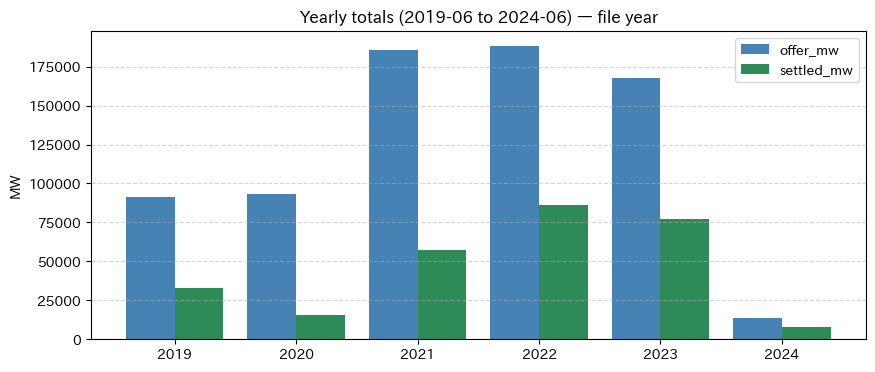

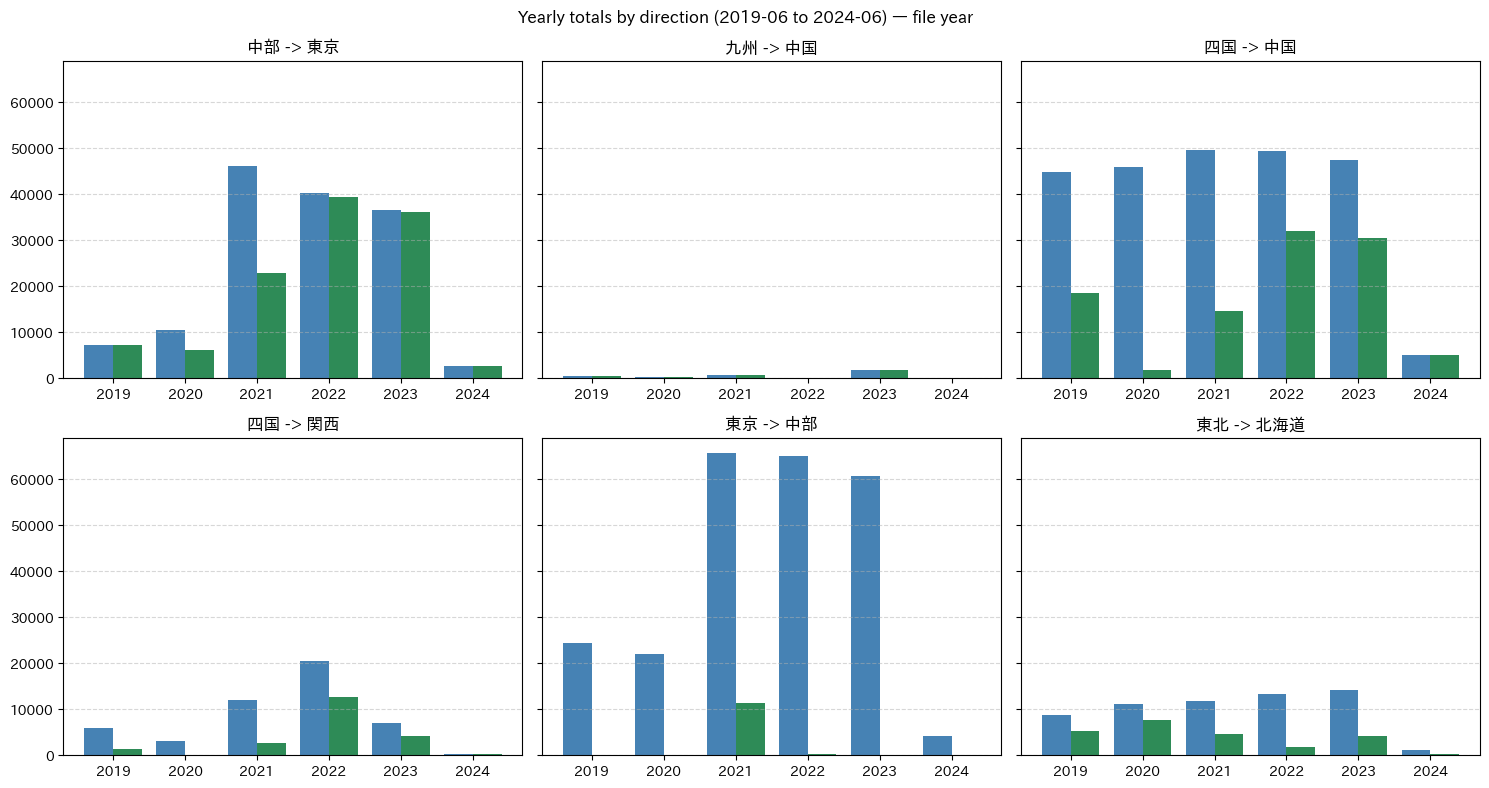

In [6]:
# Plot yearly offer_mw and settled_mw by direction for 2019-06 to 2024-06
import matplotlib.pyplot as plt
import numpy as np

# Ensure required columns exist
required_cols = {'direction', 'period_start', 'offer_mw', 'settled_mw', 'source_file'}
missing = required_cols - set(transmission_df.columns)
if missing:
    raise ValueError(f"Missing columns for plotting: {missing}")

# Filter window
start_date = pd.Timestamp('2019-06-01')
end_date = pd.Timestamp('2024-06-30')
mask = (transmission_df['period_start'] >= start_date) & (transmission_df['period_start'] <= end_date)
plot_df = transmission_df.loc[mask].copy()

# Derive year from source file name (e.g., transmission_rights_2021.csv -> 2021)
plot_df['year'] = plot_df['source_file'].str.extract(r'(\d{4})', expand=False).astype(int)

# Aggregate per year and direction based on file year
agg = plot_df.groupby(['year', 'direction'], as_index=False)[['offer_mw', 'settled_mw']].sum()

# Overall aggregation per year
overall = agg.groupby('year', as_index=False)[['offer_mw', 'settled_mw']].sum()

# Plot: Overall
years = overall['year'].tolist()
x = np.arange(len(years))
width = 0.4

fig_overall, ax_overall = plt.subplots(figsize=(10, 4))
ax_overall.bar(x - width/2, overall['offer_mw'], width=width, color='steelblue', label='offer_mw')
ax_overall.bar(x + width/2, overall['settled_mw'], width=width, color='seagreen', label='settled_mw')
ax_overall.set_xticks(x)
ax_overall.set_xticklabels(years, rotation=0)
ax_overall.set_title('Yearly totals (2019-06 to 2024-06) — file year')
ax_overall.set_ylabel('MW')
ax_overall.legend()
ax_overall.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Subplots per direction, in a grid (width=3)
directions = sorted(agg['direction'].unique())
cols = 3
rows = int(np.ceil(len(directions) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4), sharey=True)
axes = np.array(axes).reshape(rows, cols)

for idx, direction in enumerate(directions):
    r = idx // cols
    c = idx % cols
    ax = axes[r, c]
    sub = agg[agg['direction'] == direction].copy()
    # Align years to full range for consistency
    sub = sub.set_index('year')
    full_years = years
    sub = sub.reindex(full_years).fillna(0)
    x = np.arange(len(full_years))
    ax.bar(x - width/2, sub['offer_mw'], width=width, color='steelblue')
    ax.bar(x + width/2, sub['settled_mw'], width=width, color='seagreen')
    ax.set_xticks(x)
    ax.set_xticklabels(full_years, rotation=0)
    ax.set_title(direction)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Hide unused axes
for extra_idx in range(len(directions), rows*cols):
    r = extra_idx // cols
    c = extra_idx % cols
    axes[r, c].axis('off')

fig.suptitle('Yearly totals by direction (2019-06 to 2024-06) — file year')
fig.tight_layout()
plt.show()